This is a notebook designed to allow a user to import a greyscale SEM image of a sample, and using Python, allow mapping of the image based on RGB value. 

This can be implemented using scikit-image, an image processing Python package that works with numpy arrays. Within scikit-image, images are represented as NumPy arrays: e.g., 2D arrays for grayscale 2-D images. 

In [1]:
# imports
import skimage
from skimage import io
from skimage.filters import try_all_threshold
from skimage.morphology import closing, opening, square
from skimage.filters import threshold_otsu

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import scipy.signal

In [2]:
# load your own image as NumPy array
sem_image = io.imread('../McDonald_SEM.tif')

In [3]:
sem_image # this is now a Numpy Array.

array([[128, 105,  86, ..., 105, 128, 110],
       [ 97, 105,  97, ..., 105, 102, 112],
       [112, 105,  97, ...,  79, 117, 105],
       ...,
       [112, 146, 178, ..., 110, 117, 100],
       [ 97, 112, 157, ..., 117, 112, 102],
       [110, 117, 155, ...,  97, 128, 115]], dtype=uint8)

In [4]:
sem_image.ndim # this means 2D

2

In [5]:
np.max(sem_image), np.min(sem_image) #256 bit grayscale

(252, 0)

In [6]:
type(sem_image)

numpy.ndarray

In [7]:
sem_image.shape

(532, 556)

In [8]:
sem_image.size

295792

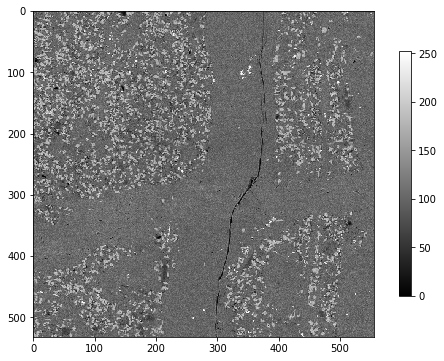

In [9]:
# take the nparray of sem_image and plotting it as an image using matplotlib.pyplot
plt.figure(figsize=(9, 6 ))
plt.imshow(sem_image, cmap='gray')
plt.colorbar(shrink=0.75)

<strong>Now that we have an image loaded as a nparray, we can do more with the data than show it as an image. We can also call up a histogram of the data in order to extract meaningful ranges of greyscale values from patterns in the data, which may point toward certain data groups that reflect individual minerals.

([array([  1.,   0.,  24., 179., 191.,  50.,  40.,  39.,   5.,   3.]),
  array([  0.,   3.,  24., 158., 201.,  53.,  38.,  50.,   4.,   1.]),
  array([  0.,   5.,  22., 186., 182.,  47.,  49.,  34.,   5.,   2.]),
  array([  2.,   3.,  13., 188., 187.,  44.,  49.,  44.,   1.,   1.]),
  array([  5.,   3.,  19., 173., 192.,  44.,  56.,  37.,   3.,   0.]),
  array([  6.,   4.,  21., 185., 172.,  52.,  48.,  41.,   3.,   0.]),
  array([  2.,   8.,  30., 180., 166.,  51.,  50.,  41.,   4.,   0.]),
  array([  1.,   6.,  31., 171., 182.,  51.,  43.,  45.,   1.,   1.]),
  array([  2.,   8.,  31., 174., 186.,  39.,  42.,  49.,   0.,   1.]),
  array([  0.,   6.,  30., 198., 167.,  36.,  50.,  43.,   1.,   1.]),
  array([  1.,   5.,  30., 182., 172.,  42.,  53.,  42.,   5.,   0.]),
  array([  1.,   4.,  25., 179., 171.,  36.,  45.,  65.,   3.,   3.]),
  array([  1.,   5.,  19., 175., 179.,  51.,  45.,  52.,   3.,   2.]),
  array([  1.,   4.,  25., 181., 167.,  53.,  47.,  46.,   6.,   2.]),
  arra

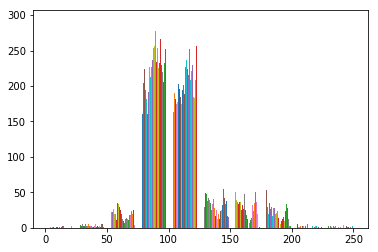

In [10]:
# use matplotlib.pyplot to plot a histogram of the data in sem_image
# note that this will return a full range, taking and displaying each row as individual vectors. 

plt.hist(sem_image)

<h3>Ravel the data for faster processing</h3>

The above code for generating a histogram runs a bit slowly, and for bigger files containing more pixels, will be even slower. This is because plt.hist() generates a histogram for each and every individual row in the dataset, and outputs individual arrays as data. To avoid this, and to speed up the process, can use the ravel method on sem_image. Ravel turns the returned arrays into one massive vector, and forces plt.hist() to make one histogram for all rows.

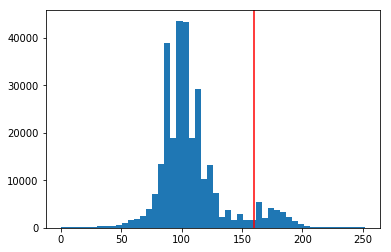

In [11]:
# using bins returns a specific range for the histogram.
# save the data from plt.hist into n, bins, and _ variable.
n, bins, _ = plt.hist(sem_image.ravel(), bins=50)
plt.axvline(160, c='r')

(array([  238.,   304.,   529.,  1194.,  3463.,  7529., 43300., 78511.,
        78447., 36466., 11619.,  6305.,  4901., 10007.,  8304.,  3175.,
          689.,   227.,   226.,   358.]),
 array([  0. ,  12.6,  25.2,  37.8,  50.4,  63. ,  75.6,  88.2, 100.8,
        113.4, 126. , 138.6, 151.2, 163.8, 176.4, 189. , 201.6, 214.2,
        226.8, 239.4, 252. ]),
 <a list of 20 Patch objects>)

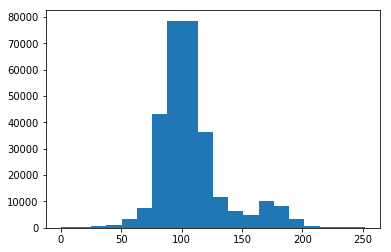

In [12]:
plt.hist(sem_image.ravel(), bins=20)

As well as matplotlib.pyplot, can also use the seaborn data visualization library (based on matplotlib) to display a smoothed histogram of the data by using a seaborn distribution plot. 

/anaconda3/envs/image_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


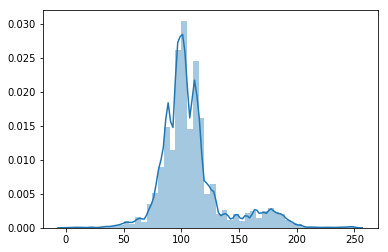

In [13]:
# take a random selection from the image. Take 5% of pixels randomly and give me the histogram
sns.distplot(np.random.choice(sem_image.ravel(), size=int(0.05*sem_image.size)))

In [14]:
# learning note: to take all the rows from the 100th column of the data, use below code.
# plt.hist(sem_image[:, 100])

Now that we have a histogram, and an idea for where the dominant data ranges stand, it would be useful to be able to find those dominant populations, extract them, and assign them to different minerals/greyscales for mapping. For example, access particular values at 100 greyscale which have a count of 40000. Then, find the indexes of the pixels with greyscale values between the population limits, and then assign them to a mineral. This index could be found from the histogram data, saved in variable 'n' above.

As an initial step for testing this concept, let's try extracting values from the sem_image which would only return brighter pixels. 

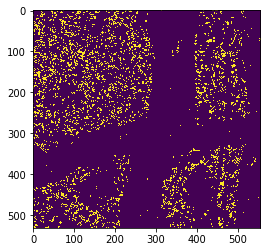

In [15]:
# extract bright minerals from data set with greyscale above 155
# save data (a list of booleans)
# plot the data as yellow in image

bright_minerals = sem_image >= 155

plt.imshow(bright_minerals)

In [16]:
# We can calculate how much of the requested grayscale data is present in our plots now.
measured_bright_grains = 1 - bright_minerals.sum() / bright_minerals.size
mbg_percent = measured_bright_grains * 100
bg_calc = 100 - mbg_percent

print(f'Dark purple space in image = {measured_bright_grains:.1%}')
print(f'Therefore yellow space in image (bright grains) = {bg_calc:.2}%')


Dark purple space in image = 90.6%
Therefore yellow space in image (bright grains) = 9.4%


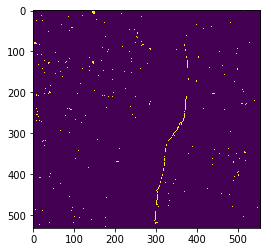

In [17]:
# extract dark values from data set (i.e. porosity) with greyscale below 50
porosity = sem_image < 50

plt.imshow(porosity)

In [18]:
# We can calculate how much of the requested grayscale data is present in our plots now.
measured_porosity = 1 - porosity.sum() / porosity.size
m_por_percent = measured_porosity * 100
porosity_calc = 100 - m_por_percent

print(f'Dark purple space in image = {measured_porosity:.1%}')
print(f'Therefore yellow space in image (porosity) = {porosity_calc:.2}%')


Dark purple space in image = 99.3%
Therefore yellow space in image (porosity) = 0.68%


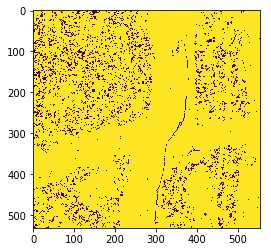

In [19]:
# then extract values between brighter minerals and porosity.
grey = (50 < sem_image) & (sem_image < 160)

plt.imshow(grey)
#plt.imshow(black)


In [20]:
# We can calculate how much of the requested grayscale data is present in our plots now.
measured_grey = 1 - grey.sum() / grey.size
mg_percent = measured_grey * 100
g_calc = 100 - mg_percent

print(f'Dark purple space in image = {measured_grey:.1%}')
print(f'Therefore yellow space in image (grains which are neither porosity nor bright minerals) = {g_calc:.3}%')


Dark purple space in image = 9.1%
Therefore yellow space in image (grains which are neither porosity nor bright minerals) = 90.9%


Great, now we have a means of 1) bringing in an image as a nparray 2) plotting it as an image 3) plotting the data as a histogram and 4) extracting values to carry out point counting on specific value ranges.

Let's explore how to extract meaningful data ranges from the data by using scipy to find peaks from the data of the histogram.

<strong> This section on peak finder is still a work in progress!! 

In [21]:
# peak finder in scipy: use this to find ranges of data to feed into from the histogram (stored as n here)
scipy.signal.find_peaks(n) # returns indices of peaks

(array([ 7, 17, 19, 22, 24, 27, 29, 32, 34, 45]), {})

Let's make some functions to allow the user to carry out the above steps.

In [53]:
def img_to_nparray(user_image):
    np_array = io.imread(user_image)
    return np_array

In [56]:
# import image from tif file, convert it to a nparray, and display the data in matplotlib.pyplot.
def image_as_nparray(user_image):
    """
    Allows a user to enter the path of an image from their directory, and store it as a nparray.
    """
    np_array = img_to_nparray(user_image)
    image_to_plot = plt.imshow(np_array)
    
    
    return image_to_plot   

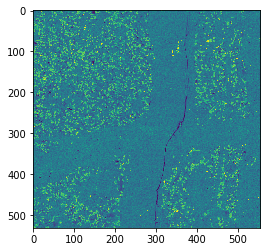

In [57]:
image_as_nparray('../McDonald_SEM.tif')
image_test = image_as_nparray('../McDonald_SEM.tif')
image_test
#show_image_as_pyplot(image_as_nparray)


In [58]:
def show_image_in_hist(user_image, bins=50):
    """
    Shows a pyplot histogram of the nparray data
    """
    np_array = img_to_nparray(user_image)

    return plt.hist(np_array.ravel(), bins)


(array([  100.,    88.,   108.,   115.,   131.,   155.,   281.,   331.,
          316.,   640.,  1023.,  1620.,  1870.,  2457.,  4022.,  7092.,
        13347., 38990., 18801., 43581., 43404., 18825., 29244., 10245.,
        13195.,  7305.,  2373.,  3680.,  1579.,  2987.,  1569.,  1611.,
         5454.,  2158.,  4116.,  3785.,  3258.,  2278.,  1415.,   743.,
          444.,   151.,   141.,    90.,    90.,   100.,    77.,    84.,
          156.,   167.]),
 array([  0.  ,   5.04,  10.08,  15.12,  20.16,  25.2 ,  30.24,  35.28,
         40.32,  45.36,  50.4 ,  55.44,  60.48,  65.52,  70.56,  75.6 ,
         80.64,  85.68,  90.72,  95.76, 100.8 , 105.84, 110.88, 115.92,
        120.96, 126.  , 131.04, 136.08, 141.12, 146.16, 151.2 , 156.24,
        161.28, 166.32, 171.36, 176.4 , 181.44, 186.48, 191.52, 196.56,
        201.6 , 206.64, 211.68, 216.72, 221.76, 226.8 , 231.84, 236.88,
        241.92, 246.96, 252.  ]),
 <a list of 50 Patch objects>)

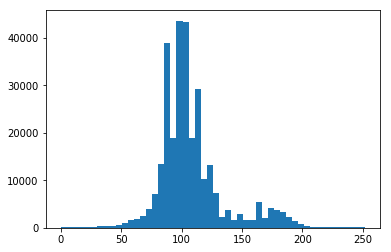

In [59]:
show_image_in_hist('../McDonald_SEM.tif')

In [65]:
def show_less_than_gs_values_of_image(user_image, gs_values):
    np_array = img_to_nparray(user_image)
    less_than = plt.imshow(np_array) < gs_values
    print(less_than)
    
    return less_than

    

TypeError: '<' not supported between instances of 'AxesImage' and 'int'

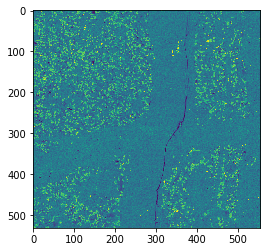

In [66]:
show_less_than_gs_values_of_image('../McDonald_SEM.tif', 50)

In [ ]:
def show_more_than_gs_values_of_image(gs_values):
    return image_as_nparray >= gs_values

In [ ]:
def show_between_gs_values_of_image(gs_value1, gs_value2):
    lower_limit = gs_value1 < image_as_nparray
    upper_limit = image_as_nparray < gs_value2
    return (lower_limit) & (upper_limit)

The following code is taken from the Image Segmentation Jupyter Notebook supplied by Agile Geoscientific as an example of other uses for image analysis in Python, using my sem_image data.

In [ ]:
# Thresholding is used to create a binary image from a grayscale image [1]. It is the simplest way to segment objects from a background.
fig, ax = try_all_threshold(sem_image, figsize=(10, 16), verbose=False)
plt.show

Using the Otsu example, from the Image_segmentation notebook, it splits the data into two: pixels which are nearest to black are rendered black, and pixels which are nearest to white are rendered white. Something like that! 

If we wanted to count the % of black pixels in the Otsu output, then we can import threshold oshu from skimage.

In [ ]:
thresh = threshold_otsu(sem_image)
binary = sem_image > thresh # this saves the image as Otsu as above.

In [ ]:
plt.imshow(binary, cmap='gray')

In [ ]:
black_space = 1 - binary.sum() / binary.size
print(f'black space = {black_space:.1%}')

In [ ]:
binary = closing(binary, square(3))
binary = opening(binary, square(3))

In [ ]:
plt.imshow(binary) # this is essentially stripping out all the highly reflective minerals

In [ ]:
binary